In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

## Modélisation mathématique du problème

Soit:

-   $\mathbf{R} = \left\{ r_{1}, r_{2}, ..., r_{n} \right\}$ une liste de requêtes emises sur le vehicule
    
-   $ \mathbf{W} = \left\{ w_{1}, w_{2}, ..., w_{n} \right\}$ le poids associé à chaque requête
    
-   $ \mathbf{U} = \left\{ u_{1}, u_{2}, ..., u_{n} \right\}$ avec $u_{i} \epsilon \left\{ 0, 1 \right\}$ une variable binaire désignant si la requete est acceptée ou pas.
    

L’objectif est d’avoir les valeurs de U qui maximisent la moyenne pondérée des poids et minimisent l'impact négatif des requêtes sur les QoS (Temps de trajet, Quantité de carburant consommée). La fonction objective peut être formulée comme suit:
<div align="center">

$$
\max \left(\sum_{i=1}^{n} \left (w_{i} x_{i} \right) + \lambda \sum_{i=1}^{n} \left (x_{i} \left (q_{t} t_{i} + q_{c} c_{i} \right) \right)\right)
$$

</div>


Où:

-   $q_{t}$ est le poids de l'objectif temps de trajet
    
-   $t_{i}$ l'impact de la requete $r_{i}$ sur le temps de trajet
    
-   $q_{c}$ est le poids de l'objectif temps de trajet
    
-   $c_{i}$ l'impact de la requete $r_{i}$ sur le temps de trajet
    
-   $\lambda$ est un facteur de pénalité pour équilibrer l'importance des poids des requêtes et des impacts sur les QoS. (L'impact a la meme echelle que les poids).

#### Architecture

<div align="center">
    <img src="modelisation_finale.png" alt="Description de l'image">
</div>

Les $  u_{i} $ sont les sorties prédites par le modèle pour la requête 
$ i $ (probabilité d'acceptation).

Le module de prediction des impacts est constitué des deux modeles suivant chacun l'architecture suivante:

<div align="center">
    <img src="modelisation_impact.png" alt="Description de l'image">
</div>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
datas = pd.read_csv('final_datas.csv')

In [4]:
datas.head()

,Longitude,Latitude,Speed,Acceleration,ActionVehicleAhead,ActionId,action_accelerate,action_decelerate,action_stop,ActionParam,ActionDuration,StartTime,EndTime,y_fuel,y_travel
0,1.469733,43.564755,13.140468,4.202313,0,3,0,0,1,0.000000,14,37,51,2.242222,-30.0
1,1.468177,43.566528,5.219182,0.003377,1,2,0,1,0,8.710846,9,55,64,-0.497640,-13.0
2,1.468899,43.564810,13.069221,-1.214671,1,1,1,0,0,4.531946,20,19,39,-109.744464,10.0
3,1.468901,43.565777,12.088279,-2.720630,1,1,1,0,0,9.109832,13,60,73,-75.229436,-9.0
4,1.469665,43.564765,15.709481,-0.578869,0,2,0,1,0,12.523312,5,47,52,18.707623,-27.0


#### Association d'un poids entre O et 1 a chaque requete

In [5]:
np.random.seed(42)
datas['weight'] = np.random.rand(len(datas)).round(2)

In [6]:
datas.head(5)

,Longitude,Latitude,Speed,Acceleration,ActionVehicleAhead,ActionId,action_accelerate,action_decelerate,action_stop,ActionParam,ActionDuration,StartTime,EndTime,y_fuel,y_travel,weight
0,1.469733,43.564755,13.140468,4.202313,0,3,0,0,1,0.000000,14,37,51,2.242222,-30.0,0.37
1,1.468177,43.566528,5.219182,0.003377,1,2,0,1,0,8.710846,9,55,64,-0.497640,-13.0,0.95
2,1.468899,43.564810,13.069221,-1.214671,1,1,1,0,0,4.531946,20,19,39,-109.744464,10.0,0.73
3,1.468901,43.565777,12.088279,-2.720630,1,1,1,0,0,9.109832,13,60,73,-75.229436,-9.0,0.60
4,1.469665,43.564765,15.709481,-0.578869,0,2,0,1,0,12.523312,5,47,52,18.707623,-27.0,0.16


In [7]:
acceleration_req = datas[datas['action_accelerate'] == 1]

deceleration_req = datas[datas['action_decelerate'] == 1]

stop_req = datas[datas['action_stop'] == 1]

#### Generation des compostions de requetes

In [8]:
def req_by_type(num_request):
    # Répartir les requêtes de manière équilibrée entre les types
    base_count = num_request // 3
    remainder = num_request % 3

    counts = [base_count, base_count, base_count]
    for i in range(remainder):
        counts[np.random.randint(0, 3)] += 1

    num_acc, num_dec, num_stop = counts

    return num_acc, num_dec, num_stop

        

def generate_compositions( num_compositions=500 ):

    compositions = []

    for _ in range(num_compositions):
        # Nombre total de requêtes dans une composition (entre 4 et 10)
        num_request = np.random.randint(4, 11)

        num_acc, num_dec, num_stop = req_by_type(num_request)

        # Sélectionner aléatoirement les requêtes de chaque type
        acc_selected = acceleration_req.sample(n=num_acc, replace=True).copy()
        dec_selected = deceleration_req.sample(n=num_dec, replace=True).copy()
        stop_selected = stop_req.sample(n=num_stop, replace=True).copy()

        # Combiner les requêtes de différents types
        composition = pd.concat([acc_selected, dec_selected, stop_selected])

        compositions.append(composition)
    
    # # Créer un DataFrame contenant toutes les compositions
    # all_compositions = pd.concat(compositions, keys=range(num_compositions))
    # # Sauvegarder en CSV
    # all_compositions.to_csv('compositions.csv', index=True)

    return compositions

In [9]:
compositions = generate_compositions()

<Figure size 720x432 with 0 Axes>

(array([66., 78., 82., 71., 60., 68., 75.]),
 array([ 4,  5,  6,  7,  8,  9, 10, 11]),
 <BarContainer object of 7 artists>)

Text(0.5, 0, 'Nombre de requêtes par composition')

Text(0, 0.5, 'Nombre de compositions')

Text(0.5, 1.0, 'Distribution du nombre de requêtes par composition')

([<matplotlib.axis.XTick at 0x2c453027d30>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

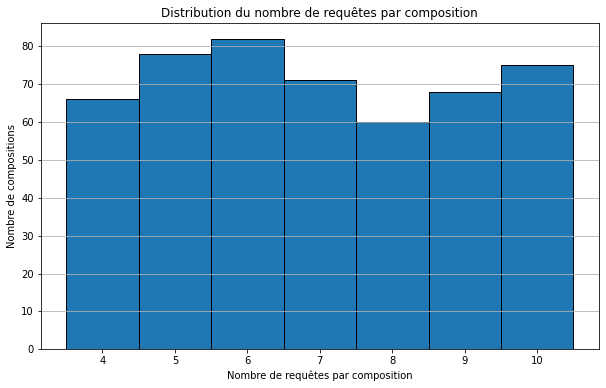

In [10]:
composition_lengths = [len(comp) for comp in compositions]

# Afficher le graphe
plt.figure(figsize=(10, 6))
plt.hist(composition_lengths, bins=range(4, 12), edgecolor='black', align='left')
plt.xlabel('Nombre de requêtes par composition')
plt.ylabel('Nombre de compositions')
plt.title('Distribution du nombre de requêtes par composition')
plt.xticks(range(4, 11))
plt.grid(axis='y')
plt.show()

In [344]:
compositions_ordered = [comp[['ActionId','ActionParam','StartTime', 'EndTime','Longitude', 
                             'Latitude', 'Speed','Acceleration', 'ActionVehicleAhead', 'weight']] for comp in compositions]

In [345]:
composition_filtered = [comp for comp in compositions_ordered if len(comp) <=6]

## Gestion des requetes

In [346]:
composition1 = composition_filtered[2]
# composition1 = composition1.values.tolist()
# composition1 = composition1[['ActionId','ActionParam','StartTime', 'EndTime','Longitude', 
#                              'Latitude', 'Speed','Acceleration', 'ActionVehicleAhead', 'y_travel', 'y_fuel', 'weight']]
composition1

,ActionId,ActionParam,StartTime,EndTime,Longitude,Latitude,Speed,Acceleration,ActionVehicleAhead,weight
548,1,3.637788,60,79,1.467514,43.567027,15.535806,1.671466,1,0.52
1298,1,6.061398,47,62,1.468705,43.565977,13.053015,-3.865097,1,0.64
3672,2,7.288713,36,54,1.468968,43.564844,4.455834,-2.732125,2,0.72
2265,2,12.340288,50,56,1.469694,43.564756,13.846621,-2.205520,0,0.63
5148,3,0.000000,70,86,1.468117,43.566597,0.401835,0.172607,0,0.62
147,3,0.000000,30,50,1.468995,43.564858,7.125251,-0.243083,1,0.50


In [109]:
comp = composition1.values.tolist()[0]

In [110]:
comp[2: 4]

[60.0, 79.0]

In [111]:
# Conflits entre deux requetes
def conflict(req1, req2):
    """
    Vérifie s'il y a un conflit entre deux requêtes basées sur leurs temps de début et de fin.
    
    Parameters:
    request1, request2 (dict): Les requêtes avec des clés 'start_time' et 'end_time' représentant les heures de début et de fin.
    
    Returns:
    bool: True s'il y a un conflit, False sinon.
    """
    if(req1[0] != req2[0]):
        start_i, fin_i = req1[2:4]
        start_j, fin_j = req2[2:4]
        # Vérification s'il y a chevauchement entre les intervalles de temps
        if (start_i < fin_j and start_j < fin_i):
            return True
        
    return False

# Detection de conflits dans une composition
def detect_conflitcs(requests):
    """
    Trouve toutes les paires de requêtes conflictuelles dans une liste de requêtes.
    
    Parameters:
    requests (list): Liste de requêtes, chaque requête étant un dict avec des clés 'start_time' et 'end_time'.
    
    Returns:
    list: Liste de tuples contenant les paires de requêtes conflictuelles.
    """
    conflicting_pairs = []
    for i in range(len(requests)):
        for j in range(i + 1, len(requests)):
            if conflict(requests[i], requests[j]):
                    conflicting_pairs.append((i, j))
    return conflicting_pairs

def is_conflict_in_combination(combinaison):
    return False if (len(detect_conflitcs(combinaison)) == 0) else True


In [120]:
# Exemple d'utilisation
requests = composition1.values.tolist()


conflicting_pairs = detect_conflitcs(requests)

is_conflict_in_combination(requests)

True

In [121]:
pd.DataFrame(requests)

,0,1,2,3,4,5,6,7,8,9,10,11
0,1.0,3.637788,60.0,79.0,1.467514,43.567027,15.535806,1.671466,1.0,7.0,-19.515209,0.52
1,1.0,6.061398,47.0,62.0,1.468705,43.565977,13.053015,-3.865097,1.0,-10.0,-91.027291,0.64
2,2.0,7.288713,36.0,54.0,1.468968,43.564844,4.455834,-2.732125,2.0,-34.0,-2.268755,0.72
3,2.0,12.340288,50.0,56.0,1.469694,43.564756,13.846621,-2.205520,0.0,-28.0,9.414965,0.63
4,3.0,0.000000,70.0,86.0,1.468117,43.566597,0.401835,0.172607,0.0,-37.0,8.868409,0.62
5,3.0,0.000000,30.0,50.0,1.468995,43.564858,7.125251,-0.243083,1.0,-27.0,7.534987,0.50


### Algorithme de selection des requetes

- #### Algorithme glouton 1
Dans ce algorithme, on trie les requetes suivant l'ordre decroissant des poids. Les requetes avec un plus grand poids sont donc selectionnés en premier. POur les autres requetes, on verifie s'ils sont en conflits avec les requetes deja selectionnes.

In [122]:
def greedy_request_selection(requests):
    """
    Sélectionne les requêtes suivant leur poids de sorte qu'il n'y ait pas de conflits.
    
    Parameters:
    requests (list): Liste de requêtes, chaque requête étant un dict avec des clés 'start_time', 'end_time', et 'weight'.
    
    Returns:
    list: Liste des requêtes sélectionnées.
    """
    # Trier les requêtes par poids décroissant
    sorted_requests = sorted(requests, key=lambda x: x[-1], reverse=True)

    selected_requests = []
    # Pour suivre les plages de temps déjà occupées

    # Parcourir les requêtes triées
    for request in sorted_requests:
        # Vérifier s'il y a un conflit avec les request déjà sélectionnées
        conf = False
        for selected in selected_requests:
            if conflict(request, selected):
                conf = True
                break
        
        if not conf:
            selected_requests.append(request)

    return selected_requests

In [123]:
pd.DataFrame(greedy_request_selection(requests))

,0,1,2,3,4,5,6,7,8,9,10,11
0,2.0,7.288713,36.0,54.0,1.468968,43.564844,4.455834,-2.732125,2.0,-34.0,-2.268755,0.72
1,2.0,12.340288,50.0,56.0,1.469694,43.564756,13.846621,-2.205520,0.0,-28.0,9.414965,0.63
2,3.0,0.000000,70.0,86.0,1.468117,43.566597,0.401835,0.172607,0.0,-37.0,8.868409,0.62


- #### Algorithme glouton 2
Dans ce algorithme, les requetes d'abord selectionnes sont les requetes dont le type a le plus grand poids total de requetes. Les autres requetes seront selectionnes en fonction de l'absence ou non de conflits avec les requetes deja selectionnees.

In [124]:
def group_by_type_and_sum_weights(requests):
    """
    Groupe les listes suivant la valeur d'une colonne spécifique et calcule la somme d'une autre colonne pour chaque groupe.

    Parameters:
    lists (list of lists): La liste principale contenant des sous-listes.
    group_col_index (int): L'index de la colonne utilisée pour le regroupement.
    sum_col_index (int): L'index de la colonne dont on veut calculer la somme.

    Returns:
    dict: Un dictionnaire où les clés sont les valeurs de la colonne spécifiée pour le regroupement,
          et les valeurs sont la somme des valeurs de la colonne spécifiée pour chaque groupe.
    """
    grouped = {}
    
    for request in requests:
        req_type = request[0]
        req_weight = request[-1]
        
        if req_type not in grouped:
            grouped[req_type] = 0
        grouped[req_type] += req_weight
    
    return grouped



def greedy_request_selection_2(requests):
    """
    Sélectionne les requêtes sans conflit en fonction du type avec le poids total le plus élevé.

    Parameters:
    requests (list of dict): La liste de requêtes.

    Returns:
    list: Liste des requêtes sélectionnées sans conflit.
    """
    # Calculer le poids total pour chaque type de requête
    grouped_weights = group_by_type_and_sum_weights(requests)

    # Identifier le type avec le poids total le plus élevé
    max_weight_type = max(grouped_weights, key=grouped_weights.get)
    
    # Sélectionner les requêtes de ce type
    selected_requests = [req for req in requests if req[0] == max_weight_type]

    other_requests = [req for req in requests if req[0] != max_weight_type]

    for request in other_requests:
        # Vérifier s'il y a un conflit avec les request déjà sélectionnées
        conf = False
        for selected in selected_requests:
            if conflict(request, selected):
                conf = True
                break
        
        if not conf:
            selected_requests.append(request)
    return selected_requests


In [147]:
pd.DataFrame(greedy_request_selection_2(requests))

,0,1,2,3,4,5,6,7,8,9,10,11
0,2.0,7.288713,36.0,54.0,1.468968,43.564844,4.455834,-2.732125,2.0,-34.0,-2.268755,0.72
1,2.0,12.340288,50.0,56.0,1.469694,43.564756,13.846621,-2.205520,0.0,-28.0,9.414965,0.63
2,1.0,3.637788,60.0,79.0,1.467514,43.567027,15.535806,1.671466,1.0,7.0,-19.515209,0.52


- #### Algorithme glouton 3 : La notion d'impact

In [126]:
#Importations des donnees de prediction

import joblib
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import mean_squared_error
import tensorflow as tf
from tensorflow.keras import backend as K

def nrmse(y_true, y_pred):
    """
    Calculate the Normalized Root Mean Square Error (NRMSE)
    """
    rms = K.sqrt(K.mean(K.square(y_pred - y_true)))
    nrmse = rms / (K.max(y_true) - K.min(y_true))
    return nrmse

def r2_score(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res/(SS_tot )

scaler_fuel = joblib.load('scaler_fuel.pkl')

scaler_travel = joblib.load('scaler_travel.pkl')

model_fuel = load_model('model_fuel.h5', custom_objects={'nrmse': nrmse, 'r2_score': r2_score})
model_travel = load_model('model_travel.h5', custom_objects={'nrmse': nrmse, 'r2_score': r2_score})

rf_fuel = joblib.load('rf_fuel.joblib')
rf_travel = joblib.load('rf_travel.joblib')

In [127]:
def reorder_request(request):
    return [
        request[6],
        request[7],
        request[8],
        request[9],
        request[10],
        request[0],
        request[1],
        request[2],
        request[3],
        request[4],
        request[5]
    ]

In [128]:
# Mise a jour des requetes avec le calcul d'impacts

from sklearn.preprocessing import OneHotEncoder

def compute_requests_impacts(requests: list):
    # Quelques modifications sur la requete

    # Convertir en tableau numpy pour un traitement plus facile
    requests_array = np.array(requests)
    
    # Séparer la première colonne pour l'encodage
    first_column = requests_array[:, 0].reshape(-1, 1)
    remaining_columns = requests_array[:, 1:]

    encoder = OneHotEncoder(sparse=False)
    # Appliquer le one-hot encoding
    encoded_first_column = encoder.fit_transform(first_column)

    # Combiner les colonnes encodées avec les colonnes restantes
    encoded_requests = np.hstack((encoded_first_column, remaining_columns))

    requests_reordered = []
    for request in encoded_requests:
        requests_reordered.append(reorder_request(request))

    # Transformer les nouvelles données en utilisant les scalers chargés
    transformed_data_fuel = scaler_fuel.transform(requests_reordered)
    transformed_data_travel = scaler_travel.transform(requests_reordered)

    # Faire des prédictions avec les modèles chargés
    # predictions_fuel = model_fuel.predict(transformed_data_fuel)
    # predictions_travel = model_travel.predict(transformed_data_travel)
    predictions_fuel_rf = rf_fuel.predict(transformed_data_fuel)
    predictions_travel_rf = rf_travel.predict(transformed_data_travel)

    # Ajouter les prédictions à chaque requête
    requests_with_predictions = []
    for i, request in enumerate(requests):
        extended_request = request + [predictions_travel_rf[i], predictions_fuel_rf[i]]
        requests_with_predictions.append(extended_request)
    return requests_with_predictions

In [129]:
comp1_df = pd.DataFrame(compute_requests_impacts(requests), columns=['ActionId', 'ActionParam', 'StartTime',
                                                                     'EndTime',	'Longitude'	,'Latitude','Speed',
                                                                     'Acceleration', 'ActionVehicleAhead','true_travel_impact', 'true_fuel_impact', 'weight', 
                                                                    'rf_predicted_travel_impact', 'rf_predicted_fuel_impact'])

In [130]:
comp1_df

,ActionId,ActionParam,StartTime,EndTime,Longitude,Latitude,Speed,Acceleration,ActionVehicleAhead,true_travel_impact,true_fuel_impact,weight,rf_predicted_travel_impact,rf_predicted_fuel_impact
0,1.0,3.637788,60.0,79.0,1.467514,43.567027,15.535806,1.671466,1.0,7.0,-19.515209,0.52,7.09,-29.597807
1,1.0,6.061398,47.0,62.0,1.468705,43.565977,13.053015,-3.865097,1.0,-10.0,-91.027291,0.64,-6.07,-84.021402
2,2.0,7.288713,36.0,54.0,1.468968,43.564844,4.455834,-2.732125,2.0,-34.0,-2.268755,0.72,-31.89,-1.332495
3,2.0,12.340288,50.0,56.0,1.469694,43.564756,13.846621,-2.205520,0.0,-28.0,9.414965,0.63,-28.68,7.004656
4,3.0,0.000000,70.0,86.0,1.468117,43.566597,0.401835,0.172607,0.0,-37.0,8.868409,0.62,-35.86,6.320132
5,3.0,0.000000,30.0,50.0,1.468995,43.564858,7.125251,-0.243083,1.0,-27.0,7.534987,0.50,-27.02,4.963282


In [131]:
def greedy_request_selection_3(requests, travel_weight, fuel_weight):
    requests_with_impacts= compute_requests_impacts(requests)

    for req in requests_with_impacts:
        req.append(travel_weight* req[-2] + fuel_weight * req[-1])

    # Trier les requêtes selon les impacts
    sorted_requests = sorted(requests_with_impacts, key=lambda x: x[-1], reverse=True)

    selected_requests = []
    # Pour suivre les plages de temps déjà occupées

    # Parcourir les requêtes triées
    for request in sorted_requests:
        # Vérifier s'il y a un conflit avec les request déjà sélectionnées
        conf = False
        for selected in selected_requests:
            if conflict(request, selected):
                conf = True
                break
        
        if not conf:
            selected_requests.append(request)

    return selected_requests

In [132]:
pd.DataFrame(compute_requests_impacts(requests))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1.0,3.637788,60.0,79.0,1.467514,43.567027,15.535806,1.671466,1.0,7.0,-19.515209,0.52,7.09,-29.597807
1,1.0,6.061398,47.0,62.0,1.468705,43.565977,13.053015,-3.865097,1.0,-10.0,-91.027291,0.64,-6.07,-84.021402
2,2.0,7.288713,36.0,54.0,1.468968,43.564844,4.455834,-2.732125,2.0,-34.0,-2.268755,0.72,-31.89,-1.332495
3,2.0,12.340288,50.0,56.0,1.469694,43.564756,13.846621,-2.205520,0.0,-28.0,9.414965,0.63,-28.68,7.004656
4,3.0,0.000000,70.0,86.0,1.468117,43.566597,0.401835,0.172607,0.0,-37.0,8.868409,0.62,-35.86,6.320132
5,3.0,0.000000,30.0,50.0,1.468995,43.564858,7.125251,-0.243083,1.0,-27.0,7.534987,0.50,-27.02,4.963282


In [133]:
pd.DataFrame(greedy_request_selection_3(requests, 0.5, 0.5))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,2.0,12.340288,50.0,56.0,1.469694,43.564756,13.846621,-2.205520,0.0,-28.0,9.414965,0.63,-28.68,7.004656,-10.837672
1,3.0,0.000000,30.0,50.0,1.468995,43.564858,7.125251,-0.243083,1.0,-27.0,7.534987,0.50,-27.02,4.963282,-11.028359
2,1.0,3.637788,60.0,79.0,1.467514,43.567027,15.535806,1.671466,1.0,7.0,-19.515209,0.52,7.09,-29.597807,-11.253903


In [80]:
def compute_score(combinaison, lambdaa, travel_weight, fuel_weight):
    sum = 0
    for request in combinaison:
        sum += request[-3] + lambdaa* (travel_weight* request[-2] + fuel_weight* request[-1])

    return sum

def compute_impacts(combination, t_weight, f_weight):
    sum = 0
    for request in combination:
        sum += (t_weight* request[-2] + f_weight* request[-1])

    return sum


In [39]:
def compute_total_weight(combination):
    sum = 0
    for req in combination:
        sum += req[-3]
    return sum

In [811]:
from itertools import combinations
import math

def find_best_combination(composition):
    best_combination = []
    best_score = - math.inf

    # composition_with_impacts= compute_requests_impacts(composition)
    
    for i in range(2, len(composition)+1):
        combination_list = combinations(composition, i)
        for combo in combination_list:
            
            if not is_conflict_in_combination(combo):
                # print(pd.DataFrame(combo))
                combo_score = compute_score(combo, 0.01, 0.5, 0.5)
                if best_score < combo_score:
                    best_combination = combo
                    best_score = combo_score
    
    return best_combination, best_score


In [154]:
# find_best_combination(requests)

In [812]:
bc, bs= find_best_combination(compute_requests_impacts(requests))
pd.DataFrame(bc)
bs

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,2.0,7.288713,36.0,54.0,1.468968,43.564844,4.455834,-2.732125,2.0,-34.0,-2.268755,0.72,-31.89,-1.332495
1,2.0,12.340288,50.0,56.0,1.469694,43.564756,13.846621,-2.205520,0.0,-28.0,9.414965,0.63,-28.68,7.004656
2,3.0,0.000000,70.0,86.0,1.468117,43.566597,0.401835,0.172607,0.0,-37.0,8.868409,0.62,-35.86,6.320132


1.5478114636471791

In [211]:
len(composition_ordered)

500

In [213]:
def df_to_tuple(df):
    return tuple([tuple(row) for row in df.values])

best_combination = {}

for i in range(len(composition_ordered)):

    best_combination[i] = find_best_combination(composition_ordered[i].values.tolist())

In [197]:
pd.DataFrame(best_combination[0][0])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,2.0,11.008095,68.0,79.0,1.468530,43.56616,8.726285,-4.000000,0.0,-25.0,8.247224,0.79,-25.50,8.327352
1,3.0,0.000000,34.0,45.0,1.469164,43.56496,5.916271,0.601337,1.0,-28.0,-10.860974,0.15,-28.46,-7.560540


In [202]:
pd.DataFrame([t for t in best_combination.keys() if len(best_combination[t][0]) > 4])

,0
0,18
1,64
2,126
3,163
4,165


In [172]:
len(best_combination.keys())

226

In [208]:
pd.DataFrame(composition_filtered[163])

,ActionId,ActionParam,StartTime,EndTime,Longitude,Latitude,Speed,Acceleration,ActionVehicleAhead,y_travel,y_fuel,weight
3410,1,4.707073,41,48,1.468746,43.565934,14.593123,-3.577875,0,4.0,-23.553680,0.41
4178,1,7.372074,43,55,1.468437,43.566256,17.705084,3.512349,1,2.0,-17.439193,0.33
3416,2,6.660502,30,35,1.469940,43.565089,15.674146,-2.793227,1,-1.0,16.333320,0.31
3220,2,2.475124,18,34,1.468197,43.564407,11.854429,4.005028,2,-30.0,-0.834226,0.51
5216,3,0.000000,60,69,1.469983,43.564960,14.127148,2.704683,3,-30.0,-0.298536,0.44


In [209]:
pd.DataFrame(find_best_combination(composition_filtered[163].values.tolist())[0])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1.0,4.707073,41.0,48.0,1.468746,43.565934,14.593123,-3.577875,0.0,4.0,-23.553680,0.41,4.01,-27.812911
1,1.0,7.372074,43.0,55.0,1.468437,43.566256,17.705084,3.512349,1.0,2.0,-17.439193,0.33,4.65,-26.622234
2,2.0,6.660502,30.0,35.0,1.469940,43.565089,15.674146,-2.793227,1.0,-1.0,16.333320,0.31,-2.97,12.715535
3,2.0,2.475124,18.0,34.0,1.468197,43.564407,11.854429,4.005028,2.0,-30.0,-0.834226,0.51,-19.34,14.443309
4,3.0,0.000000,60.0,69.0,1.469983,43.564960,14.127148,2.704683,3.0,-30.0,-0.298536,0.44,-34.60,3.756961


#### La methode absolue

In [165]:
from collections import defaultdict
from itertools import product
from itertools import permutations

def group_request_by_type(requests):
    # Création d'un dictionnaire avec des listes comme valeurs par défaut
    groupes = defaultdict(list)
    
    # Parcours de chaque sous-liste dans la liste principale
    for req in requests:
        # Extraction de la valeur de la première colonne
        cle = req[0]
        # Ajout de la sous-liste au groupe correspondant
        groupes[cle].append(req)
    
    # Conversion du defaultdict en dictionnaire normal (optionnel)
    return dict(groupes)

def compute_total_weight(combinaison):
    sum = 0
    for req in combinaison:
        sum += req[-1]
    return sum

# Fonction pour générer des combinaisons sans conflit pour un type de base donné
def generate_combinations_for_base_type(base_type, grouped_requests):
    all_combinaisons = []

    # Obtenir les autres types de requêtes
    other_types = [t for t in grouped_requests if t != base_type]

    for perm in permutations(other_types):
        combinaison = grouped_requests[base_type]
        for other_type in perm:
            for request in grouped_requests[other_type]:
                # Vérifier s'il y a un conflit avec les request déjà sélectionnées
                conf = False
                for selected in combinaison:
                    if conflict(request, selected):
                        conf = True
                        break
                
                if not conf:
                    combinaison.append(request)
            
            all_combinaisons.append(combinaison)
    return all_combinaisons

def selection(requests):
    best_combinaison = []
    max_comb_weight = 0

    # Trier les requêtes par poids décroissant
    sorted_requests = sorted(requests, key=lambda x: x[-1], reverse=True)

    groupes = group_request_by_type(sorted_requests)

    # Trier chaque groupe selon le troisième élément (par exemple)
    for base_type in groupes.keys():
         # Obtenir les autres types de requêtes
        other_types = [t for t in groupes if t != base_type]

        for perm in permutations(other_types):
            combinaison = list(groupes[base_type])
            for other_type in perm:
                for request in groupes[other_type]:
                    # Vérifier s'il y a un conflit avec les request déjà sélectionnées
                    conf = False
                    for selected in combinaison:
                        if conflict(request, selected):
                            conf = True
                            break
                    
                    if not conf:
                        combinaison.append(request)
            
            combinaison_weight = compute_total_weight(combinaison)
            if combinaison_weight > max_comb_weight :
                best_combinaison = combinaison
                max_comb_weight = combinaison_weight

    return best_combinaison



In [167]:
pd.DataFrame(selection(requests))

,0,1,2,3,4,5,6,7,8,9,10,11
0,2.0,10.124752,39.0,46.0,1.468573,43.564648,4.573838,-3.622729,4.0,-30.0,-2.712101,0.71
1,2.0,4.093955,56.0,66.0,1.468753,43.565927,12.927318,2.147102,1.0,-26.0,5.998625,0.61
2,2.0,4.403356,52.0,59.0,1.467999,43.566807,7.800227,-2.352220,1.0,-4.0,0.790045,0.48
3,3.0,0.000000,21.0,29.0,1.468111,43.564315,8.104013,2.233080,3.0,-30.0,15.042258,0.73
4,1.0,3.140044,69.0,87.0,1.467767,43.567178,10.560360,-0.745790,0.0,-8.0,-112.341215,0.02


In [347]:
comp_with_impacts = compute_requests_impacts(composition1.values.tolist())

In [230]:
composition1

,ActionId,ActionParam,StartTime,EndTime,Longitude,Latitude,Speed,Acceleration,ActionVehicleAhead,y_travel,y_fuel,weight
548,1,3.637788,60,79,1.467514,43.567027,15.535806,1.671466,1,7.0,-19.515209,0.52
1298,1,6.061398,47,62,1.468705,43.565977,13.053015,-3.865097,1,-10.0,-91.027291,0.64
3672,2,7.288713,36,54,1.468968,43.564844,4.455834,-2.732125,2,-34.0,-2.268755,0.72
2265,2,12.340288,50,56,1.469694,43.564756,13.846621,-2.205520,0,-28.0,9.414965,0.63
5148,3,0.000000,70,86,1.468117,43.566597,0.401835,0.172607,0,-37.0,8.868409,0.62
147,3,0.000000,30,50,1.468995,43.564858,7.125251,-0.243083,1,-27.0,7.534987,0.50


In [ ]:
composition_filtered = [comp for comp in compositions_ordered if len(comp) <=6]

In [410]:
base_name = comp

compositions_by_length = {}
compositions_with_impact = {}

for i in range(4, 11):
    compositions_by_length[i] = [comp for comp in compositions_ordered if len(comp) == i]
    compositions_with_impact[i] = []
    for j in range(len(compositions_by_length[i])):
        compositions_with_impact[i].append(compute_requests_impacts(compositions_by_length[i][j].values.tolist()))


In [413]:
pd.DataFrame(compositions_with_impact[4][0])

,0,1,2,3,4,5,6,7,8,9,10,11
0,1.0,3.296977,66.0,80.0,1.467941,43.566903,4.780185,-4.000000,0.0,0.84,-23.57,-67.499667
1,2.0,11.008095,68.0,79.0,1.468530,43.566160,8.726285,-4.000000,0.0,0.79,-25.50,8.327352
2,3.0,0.000000,34.0,45.0,1.469164,43.564960,5.916271,0.601337,1.0,0.15,-28.46,-7.560540
3,3.0,0.000000,16.0,28.0,1.468079,43.564281,5.677399,1.901320,2.0,0.08,-25.81,-2.712641


### Creation du modele

In [214]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import word_tokenize

In [369]:
data_tensor = torch.tensor(comp_with_impacts, dtype=torch.float32).unsqueeze(0)
data_tensor

tensor([[[  1.0000,   3.6378,  60.0000,  79.0000,   1.4675,  43.5670,  15.5358,
            1.6715,   1.0000,   0.5200,   7.0900, -29.5978],
         [  1.0000,   6.0614,  47.0000,  62.0000,   1.4687,  43.5660,  13.0530,
           -3.8651,   1.0000,   0.6400,  -6.0700, -84.0214],
         [  2.0000,   7.2887,  36.0000,  54.0000,   1.4690,  43.5648,   4.4558,
           -2.7321,   2.0000,   0.7200, -31.8900,  -1.3325],
         [  2.0000,  12.3403,  50.0000,  56.0000,   1.4697,  43.5648,  13.8466,
           -2.2055,   0.0000,   0.6300, -28.6800,   7.0047],
         [  3.0000,   0.0000,  70.0000,  86.0000,   1.4681,  43.5666,   0.4018,
            0.1726,   0.0000,   0.6200, -35.8600,   6.3201],
         [  3.0000,   0.0000,  30.0000,  50.0000,   1.4690,  43.5649,   7.1253,
           -0.2431,   1.0000,   0.5000, -27.0200,   4.9633]]])

In [914]:
def objectif(composition, lambdaa, travel_weight, fuel_weight):
    obj = []
    for req in composition:
        obj.append(req[-3] + lambdaa* (travel_weight* req[-2] + fuel_weight* req[-1]))
    return obj

def true_output(batch):
    output = []
    for i in range(len(batch)):
        composition_solution, _ = find_best_combination(batch[i])
        obj = objectif(composition_solution, 0.01, 0.5, 0.5)
        max_index = obj.index(max(obj))
        best_request = composition_solution[max_index]
        # Créer une nouvelle liste avec des 0 partout sauf à l'index de la valeur maximale
        transformed_values = [[1] if req == best_request else [0] for req in batch[i]]
        output.append(transformed_values)
    return output


def all_output(batch):
    all_output = []
    for i in range(len(batch)):
        output = []
        requests = batch[i]
        composition_solution, _ = find_best_combination(batch[i])
        obj = objectif(composition_solution, 0.01, 0.5, 0.5)

        composition_solution_ordered = [x for _,x in sorted(zip(obj, composition_solution), reverse=True)]
        for j in range(len(composition_solution_ordered)):
            current_best_request = composition_solution_ordered[j]
            output.append([[1] if req == current_best_request else [0] for req in requests])
        
        for k in range(len(requests) - len(composition_solution_ordered)):
            output.append([[0]]*len(requests))

        all_output.append(output)
    return all_output

In [1063]:
def filter_requests_list(requests_list, selected_requests):
    n_requests = len(requests_list)
    considered_requests = [1] *  n_requests

    for i in range(n_requests):
        if selected_requests[i] == [1]:
            considered_requests[i] = 0
            for j in range(n_requests):
                if conflict(requests_list[i], requests_list[j]):
                    considered_requests[j] = 0

    return [np.multiply(a, b).tolist() for a, b in zip(requests_list, considered_requests)]

def filter_batch(batch, selected_requests):
    new_batch= []
    for i in range(len(batch)):
        new_batch.append(filter_requests_list(batch[i], selected_requests[i]))
    return new_batch

In [1060]:
# [a + b for a, b in zip([[0], [1], [0], [0]] , [[0], [0] ,[0], [1]])]
# (np.array([[0], [1], [0], [0]]) + np.array([[0], [0] ,[0], [1]])).tolist()
# comp_test = compositions_with_impact[4]
# [[0], [0], [0], [1]] * len


In [843]:
e = objectif(find_best_combination(compositions_with_impact[5][3])[0],  0.01, 0.5, 0.5)
br = find_best_combination(compositions_with_impact[5][3])[0][e.index(max(e))]

In [844]:
pd.DataFrame(find_best_combination(compositions_with_impact[5][3])[0])

,0,1,2,3,4,5,6,7,8,9,10,11
0,2.0,11.96904,69.0,86.0,1.467469,43.567077,13.627320,-4.000000,1.0,0.85,-16.01,10.939783
1,3.0,0.00000,34.0,46.0,1.468572,43.564648,5.388259,-3.190171,4.0,0.83,-29.70,-8.285899
2,3.0,0.00000,36.0,47.0,1.469752,43.565205,8.698651,-4.000000,3.0,0.66,-15.50,-0.236074


In [845]:
pd.DataFrame(br).T

,0,1,2,3,4,5,6,7,8,9,10,11
0,2.0,11.96904,69.0,86.0,1.467469,43.567077,13.62732,-4.0,1.0,0.85,-16.01,10.939783


In [847]:
[1 if r == br else 0 for r in compositions_with_impact[5][3]]

[0, 1, 0, 0, 0]

In [797]:
a,b,c, d= train_test_split(compositions_with_impact[5], true_output(compositions_with_impact[5]), test_size=0.2)

In [912]:
# true_output(compositions_with_impact[7])

In [1025]:
# Conversion en donnees de train et de test

X_train_batch = {}
X_test_batch = {}
y_train_batch = {}
y_test_batch = {}

for i in range(4, 11):
    X_train, X_test, y_train, y_test = train_test_split(compositions_with_impact[i], true_output(compositions_with_impact[i]), test_size=0.2)
    X_train_batch[i] = torch.tensor(X_train, dtype=torch.float32)
    X_test_batch[i] = torch.tensor(X_test, dtype=torch.float32)
    y_train_batch[i] = torch.tensor(y_train, dtype=torch.float32)
    y_test_batch[i] = torch.tensor(y_test, dtype=torch.float32)

In [1051]:
tensor_batch = {}
batch_x_train= {}
batch_x_test = {}
batch_y_train = {}
batch_y_test = {}

for i in range(4, 11):
    X_train, X_test, y_train, y_test = train_test_split(compositions_with_impact[i], all_output(compositions_with_impact[i]), test_size=0.2)
    batch_x_train[i]= torch.tensor(X_train, dtype=torch.float32)
    batch_x_test[i] = torch.tensor(X_test, dtype=torch.float32)
    batch_y_train[i] = torch.tensor(y_train, dtype=torch.float32)
    batch_y_test[i] = torch.tensor(y_test, dtype=torch.float32)


In [1020]:
class RequestSelector(nn.Module):
    def __init__(self, embed_size, num_heads, dropout = 0.1) -> None:
        super(RequestSelector, self).__init__()
        # self.attention = nn.MultiheadAttention(embed_size, num_heads)
        self.attention = nn.TransformerEncoderLayer(d_model= embed_size, nhead= num_heads)
        self.linear1 = nn.Linear(embed_size, 16)
        # self.bn1 = nn.BatchNorm1d(hidden_dim)

        self.linear2 = nn.Linear(16, 32)
        # self.bn2 = nn.BatchNorm1d(hidden_dim2)

        self.linear3 = nn.Linear(32, 64)

        self.linear4 = nn.Linear(64, 32)

        self.linear5 = nn.Linear(32, 16)

        self.linear6 = nn.Linear(16, 1)

        self.dropout = nn.Dropout(dropout)
        
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim= 1)
        

    def forward(self, x, mask=None):
        # attn_output, _ = self.attention(x, x, x, key_padding_mask=mask)
        attn_output = self.attention(x)

        attn_output += x

        hidden = self.relu(self.linear1(attn_output))
        
        # hidden = self.dropout(hidden)

        hidden = self.relu(self.linear2(hidden))

        # hidden = self.dropout(hidden)

        hidden = self.relu(self.linear3(hidden))

        # hidden = self.dropout(hidden)

        hidden = self.relu(self.linear4(hidden))

        # hidden = self.dropout(hidden)

        hidden = self.relu(self.linear5(hidden))

        # hidden = self.dropout(hidden)

        # Passe les résultats par une couche dense pour obtenir une seule valeur par requête
        scores = self.linear6(hidden)  # (batch_size, 1)
                
        # Utiliser softmax pour obtenir la distribution de probabilité
        probabilities = self.softmax(scores)  # (batch_size, num_queries)
        
        return probabilities


In [1033]:
model = RequestSelector(12, 1)
print(model)

RequestSelector(
  (attention): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=12, out_features=12, bias=True)
    )
    (linear1): Linear(in_features=12, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=12, bias=True)
    (norm1): LayerNorm((12,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((12,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (linear1): Linear(in_features=12, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=32, bias=True)
  (linear3): Linear(in_features=32, out_features=64, bias=True)
  (linear4): Linear(in_features=64, out_features=32, bias=True)
  (linear5): Linear(in_features=32, out_features=16, bias=True)
  (linear6): Linear(in_features=16, out_features=1, bias=True)
  (dropout): D

In [1034]:
criterion = nn.CrossEntropyLoss()  # Fonction de perte pour classification
optimizer = optim.Adam(model.parameters(), lr=0.01)


In [889]:
y_test_batch[10].size(0)


15

In [1026]:
len(X_test_batch)+1

8

In [1035]:
# Liste pour stocker la perte moyenne de chaque époque
losses = []

num_epochs = 500

for epoch in range(num_epochs):
    _ = model.train()
    running_loss = 0

    for i in range(4, 11):
        optimizer.zero_grad()
        optimizer.zero_grad()  # Réinitialiser les gradients
        outputs = model(X_train_batch[i])  # Passer les données dans le modèle
        loss = criterion(outputs, y_train_batch[i])  # Calculer la perte
        loss.backward()  # Calculer les gradients
        optimizer.step()  # Mettre à jour les paramètres du modèle
        
        running_loss += loss.item()

    avg_loss = running_loss / len(X_train_batch)

    losses.append(avg_loss)  # Enregistrer la perte moyenne de l'époque
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

# Boucle d'évaluation
_ = model.eval()  # Mode évaluation
with torch.no_grad():
    correct = 0
    total = 0

    for i in range(4, 11):
        test_outputs = model(X_test_batch[i])

        # Trouver l'index du score maximum pour chaque échantillon
        max_indices = torch.argmax(test_outputs, dim=1, keepdim=True)
        
        # Créer une matrice de zéros de la même forme que les sorties
        predicted = torch.zeros_like(test_outputs)

        # Mettre l'élément correspondant au score max à 1
        _ = predicted.scatter_(1, max_indices, 1)

        total += y_test_batch[i].size(0)

        correct += (predicted == y_test_batch[i]).all(dim=1).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy on test set: {accuracy:.2f}%')
        

Epoch [1/500], Loss: 1.8531
Epoch [2/500], Loss: 1.8187
Epoch [3/500], Loss: 1.8126
Epoch [4/500], Loss: 1.7849
Epoch [5/500], Loss: 1.7904
Epoch [6/500], Loss: 1.7776
Epoch [7/500], Loss: 1.7707
Epoch [8/500], Loss: 1.7643
Epoch [9/500], Loss: 1.7309
Epoch [10/500], Loss: 1.6551
Epoch [11/500], Loss: 1.6410
Epoch [12/500], Loss: 1.7911
Epoch [13/500], Loss: 1.6590
Epoch [14/500], Loss: 1.7190
Epoch [15/500], Loss: 1.7003
Epoch [16/500], Loss: 1.6875
Epoch [17/500], Loss: 1.6682
Epoch [18/500], Loss: 1.6521
Epoch [19/500], Loss: 1.7060
Epoch [20/500], Loss: 1.5493
Epoch [21/500], Loss: 1.6127
Epoch [22/500], Loss: 1.5374
Epoch [23/500], Loss: 1.5859
Epoch [24/500], Loss: 1.4485
Epoch [25/500], Loss: 1.4436
Epoch [26/500], Loss: 1.4038
Epoch [27/500], Loss: 1.4647
Epoch [28/500], Loss: 1.5366
Epoch [29/500], Loss: 1.5202
Epoch [30/500], Loss: 1.4563
Epoch [31/500], Loss: 1.3957
Epoch [32/500], Loss: 1.4259
Epoch [33/500], Loss: 1.4091
Epoch [34/500], Loss: 1.3899
Epoch [35/500], Loss: 1

In [858]:
total

62

<Figure size 1440x576 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Loss')

Text(0.5, 1.0, 'Evolution of Loss over Epochs')

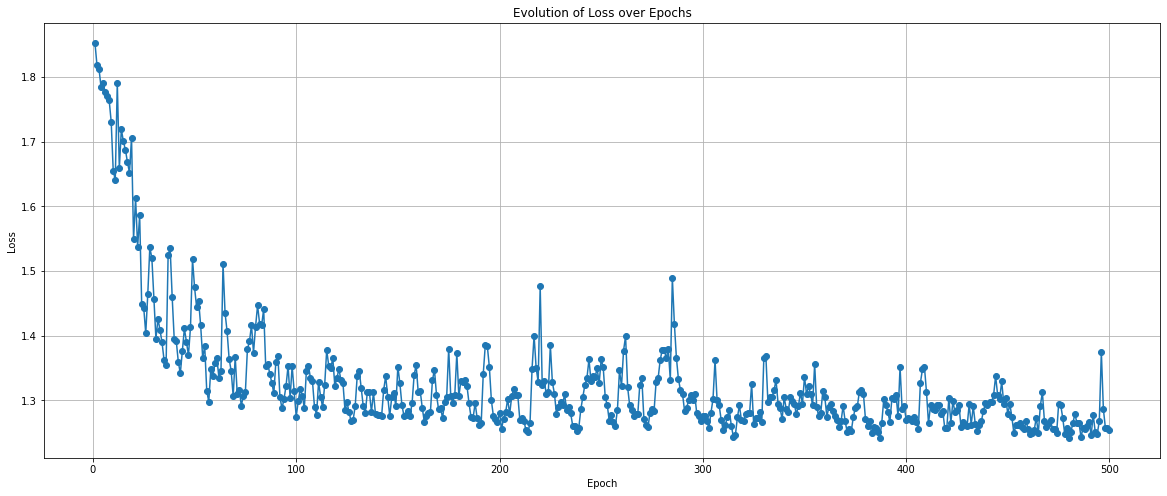

In [1036]:
# Afficher la courbe de l'évolution de la perte
plt.figure(figsize=(20, 8))
plt.plot(range(1, num_epochs+1), losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Evolution of Loss over Epochs')
plt.grid(True)
plt.show()

In [1037]:
torch.save(model.state_dict, 'model_weights.pth')

In [1068]:
global_model = RequestSelector(12, 1)

In [1076]:
c = nn.CrossEntropyLoss()  # Fonction de perte pour classification
o = optim.Adam(model.parameters(), lr=0.01)

# Liste pour stocker la perte moyenne de chaque époque
losses = []
avg_loss_batch = 0
running_loss = 0

num_epochs = 100

for epoch in range(num_epochs):
    _ = model.train()

    avg_loss_batch = 0

    for i in range(4, 11):
        optimizer.zero_grad()
        X_train = batch_x_train[i]
        selected_requests = [[[0]] * X_train.shape[1]]* len(X_train)
        running_loss = 0
        for step in range(X_train.shape[1]):
            X_train_filtered = torch.tensor(filter_batch(X_train.tolist(), selected_requests))
            outputs = global_model(X_train_filtered)  # Passer les données dans le modèle
            loss = c(outputs, batch_y_train[i][:, step])  # Calculer la perte
            loss.backward()  # Calculer les gradients
            o.step() 

            selected_requests = (torch.tensor(selected_requests) + batch_y_train[i][:, step]).tolist()

            running_loss += loss.item()
            print(running_loss)

        avg_loss_batch += running_loss / X_train.shape[1]
        break

    avg_loss = running_loss / len(batch_x_train)

    losses.append(avg_loss)  # Enregistrer la perte moyenne de l'époque
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')
    


1.3873047828674316
2.7737576961517334
3.1469157934188843
3.1735922284424305
Epoch [1/100], Loss: 0.4534
1.3872824907302856
2.773712158203125
3.1467927396297455
3.173461925238371
Epoch [2/100], Loss: 0.4534
1.387277364730835
2.7736767530441284
3.1467838287353516
3.1734574660658836
Epoch [3/100], Loss: 0.4534
1.387345790863037
2.7737417221069336
3.1468705534934998
3.1735376119613647
Epoch [4/100], Loss: 0.4534
1.3872902393341064
2.7736682891845703
3.146800845861435
3.1734719797968864
Epoch [5/100], Loss: 0.4534
1.3873263597488403
2.7737207412719727
3.1468420028686523
3.173516131937504
Epoch [6/100], Loss: 0.4534
1.387359857559204
2.7738007307052612
3.1469077467918396
3.1735790744423866
Epoch [7/100], Loss: 0.4534
1.38734769821167
2.773796796798706
3.146902769804001
3.173576094210148
Epoch [8/100], Loss: 0.4534
1.3873732089996338
2.773871898651123
3.146976947784424
3.1736463271081448
Epoch [9/100], Loss: 0.4534
1.3873575925827026
2.7738131284713745
3.146932601928711
3.1736005172133446
Epo

<Figure size 1440x576 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Loss')

Text(0.5, 1.0, 'Evolution of Loss over Epochs')

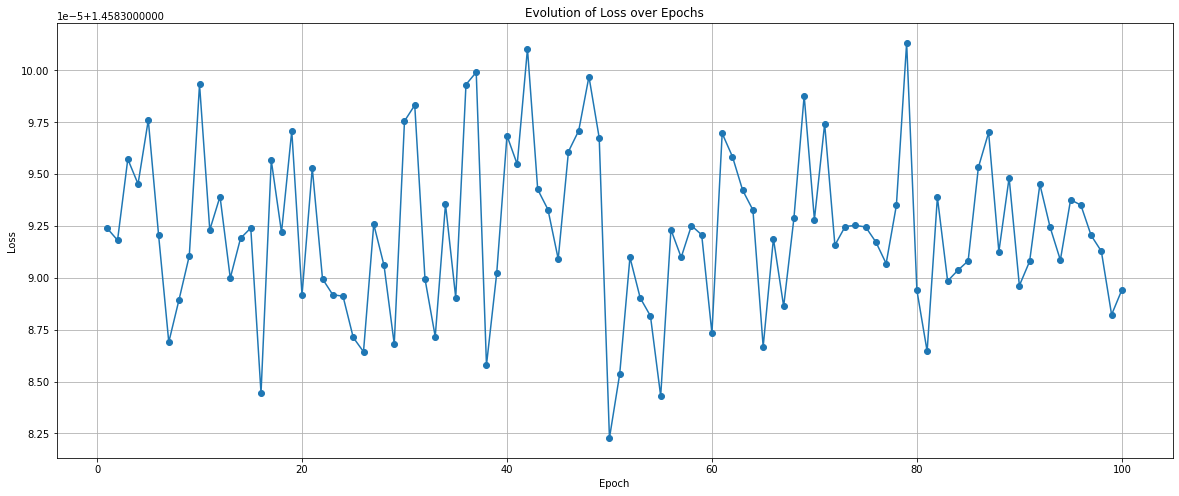

In [1070]:
# Afficher la courbe de l'évolution de la perte
plt.figure(figsize=(20, 8))
plt.plot(range(1, num_epochs+1), losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Evolution of Loss over Epochs')
plt.grid(True)
plt.show()

In [1064]:
filter_batch(batch_x_train[4].tolist(), [[[0]] * 4]* len(batch_x_train[4]))

[[[1.0,
   5.108468532562256,
   27.0,
   44.0,
   1.4693191051483154,
   43.56500244140625,
   2.954329490661621,
   -3.021207332611084,
   0.0,
   0.6600000262260437,
   -0.11999999731779099,
   -87.42799377441406],
  [2.0,
   10.170454025268555,
   55.0,
   64.0,
   1.4689693450927734,
   43.565711975097656,
   10.370810508728027,
   -2.432823896408081,
   1.0,
   0.09000000357627869,
   -26.950000762939453,
   7.1793599128723145],
  [2.0,
   8.63595199584961,
   54.0,
   66.0,
   1.4684150218963623,
   43.56627655029297,
   5.489163875579834,
   -0.5670763850212097,
   3.0,
   0.7300000190734863,
   -17.809999465942383,
   12.571634292602539],
  [3.0,
   0.0,
   47.0,
   55.0,
   1.4681845903396606,
   43.56652069091797,
   8.558942794799805,
   -0.5601748824119568,
   1.0,
   0.5299999713897705,
   -7.869999885559082,
   3.237184762954712]],
 [[1.0,
   6.727151393890381,
   37.0,
   53.0,
   1.469967246055603,
   43.564876556396484,
   14.79564380645752,
   -0.3653917908668518,
  

In [1058]:
(torch.tensor([[[0]] * 4]*50 ) + torch.tensor([[[1]] * 4]*50 )).tolist()

[[[1], [1], [1], [1]],
 [[1], [1], [1], [1]],
 [[1], [1], [1], [1]],
 [[1], [1], [1], [1]],
 [[1], [1], [1], [1]],
 [[1], [1], [1], [1]],
 [[1], [1], [1], [1]],
 [[1], [1], [1], [1]],
 [[1], [1], [1], [1]],
 [[1], [1], [1], [1]],
 [[1], [1], [1], [1]],
 [[1], [1], [1], [1]],
 [[1], [1], [1], [1]],
 [[1], [1], [1], [1]],
 [[1], [1], [1], [1]],
 [[1], [1], [1], [1]],
 [[1], [1], [1], [1]],
 [[1], [1], [1], [1]],
 [[1], [1], [1], [1]],
 [[1], [1], [1], [1]],
 [[1], [1], [1], [1]],
 [[1], [1], [1], [1]],
 [[1], [1], [1], [1]],
 [[1], [1], [1], [1]],
 [[1], [1], [1], [1]],
 [[1], [1], [1], [1]],
 [[1], [1], [1], [1]],
 [[1], [1], [1], [1]],
 [[1], [1], [1], [1]],
 [[1], [1], [1], [1]],
 [[1], [1], [1], [1]],
 [[1], [1], [1], [1]],
 [[1], [1], [1], [1]],
 [[1], [1], [1], [1]],
 [[1], [1], [1], [1]],
 [[1], [1], [1], [1]],
 [[1], [1], [1], [1]],
 [[1], [1], [1], [1]],
 [[1], [1], [1], [1]],
 [[1], [1], [1], [1]],
 [[1], [1], [1], [1]],
 [[1], [1], [1], [1]],
 [[1], [1], [1], [1]],
 [[1], [1],

In [861]:
# num_epoch = 500

# # Entraînement
# for epoch in range(num_epoch):
#     # model.train()
#     optimizer.zero_grad()
    
#     # Passer les données dans le modèle
#     outputs = model(tensor_batch[5])
    
#     # Calculer la perte
#     loss = criterion(outputs, label_batch[5])
    
#     # Backward et optimisation
#     loss.backward()
#     optimizer.step()

#     # Mettre à jour le taux d'apprentissage
#     # scheduler.step()
    

#      # Calcul de l'accuracy
#     with torch.no_grad():
#         # Trouver l'index du score maximum pour chaque échantillon
#         max_indices = torch.argmax(outputs, dim=1, keepdim=True)
        
#         # Créer une matrice de zéros de la même forme que les sorties
#         predicted = torch.zeros_like(outputs)
        
#         # Mettre l'élément correspondant au score max à 1
#         _ = predicted.scatter_(1, max_indices, 1)
        
#         # Comparer les prédictions aux étiquettes réelles
#         correct = (predicted == label_batch[5]).all(dim=1).sum().item()
        
#         # Calculer l'accuracy
#         accuracy = correct / label_batch[5].size(0)

#     # Afficher les résultats toutes les 10 époques
#     if (epoch + 1) % 10 == 0:
#         print(f'Epoch [{epoch+1}/{num_epoch}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')

In [730]:
outputs[-1]

tensor([[9.9827e-01],
        [1.7287e-03],
        [1.3705e-23],
        [5.3328e-19],
        [3.0324e-42]], grad_fn=<SelectBackward0>)

In [731]:
label_batch[5][-1]

tensor([[1.],
        [0.],
        [0.],
        [0.],
        [0.]])

In [394]:
outputs

tensor([[[1.1285e-01],
         [2.9012e-04],
         [6.8710e-02],
         [6.0424e-01],
         [7.1876e-03],
         [2.0673e-01]]], grad_fn=<SoftmaxBackward0>)

In [395]:
y_true

tensor([[[0],
         [0],
         [1],
         [0],
         [0],
         [0]]])

In [342]:
class SelectorLoss(nn.Module):
    def __init__(self) -> None:
        super(SelectorLoss).__init__()
    
    def forward(self, probabilities, x):
        weights = x[:, :, -3]
        impact_travel = x[:, :, -2]
        impact_co2 = x[:, :, -1]

        max_prob_indices = torch.argmax(output, dim=1).squeeze()

        max_weight = weights[torch.arange(weights.size(0)), max_prob_indices]

        max_impact_travel = impact_travel[torch.arange(weights.size(0)), max_prob_indices]

        max_impact_co2 = impact_co2[torch.arange(weights.size(0)), max_prob_indices]

        return max_weight, max_impact_travel, max_impact_co2
    

In [310]:
x = torch.rand(2,5, 8)

In [311]:
output = model(x)

In [312]:
output

tensor([[[0.2002],
         [0.1985],
         [0.2013],
         [0.2018],
         [0.1983]],

        [[0.2001],
         [0.1984],
         [0.2014],
         [0.2018],
         [0.1983]]], grad_fn=<SoftmaxBackward0>)

In [314]:
max_prob_indices = torch.argmax(output, dim=1)

In [319]:
torch.gather(x, dim=1, index=max_prob_indices.unsqueeze(-1)).squeeze(1)

tensor([[0.9857],
        [0.8102]])

In [321]:
weights = x[:, :, -1]

In [330]:
weights

tensor([[0.1180, 0.6762, 0.6300, 0.2696, 0.7094],
        [0.3701, 0.6818, 0.1004, 0.1990, 0.7067]])

In [332]:
max_prob_indices.squeeze()

tensor([3, 3])

In [341]:
weights[torch.arange(weights.size(0)), max_prob_indices.squeeze()]

tensor([0.2696, 0.1990])

In [336]:
torch.arange(weights.size(0))

tensor([0, 1])

In [339]:
weights[torch.tensor([0,1]), torch.tensor([3,3])]

tensor([0.2696, 0.1990])

In [328]:
x

tensor([[[0.7451, 0.5990, 0.6295, 0.4110, 0.3958, 0.7719, 0.7304, 0.1180],
         [0.2620, 0.4704, 0.9098, 0.3269, 0.5068, 0.6982, 0.7393, 0.6762],
         [0.8011, 0.6834, 0.9137, 0.8449, 0.7256, 0.6804, 0.3726, 0.6300],
         [0.9857, 0.1552, 0.8767, 0.5078, 0.2933, 0.4832, 0.2168, 0.2696],
         [0.0883, 0.3158, 0.0330, 0.9844, 0.3484, 0.6316, 0.3342, 0.7094]],

        [[0.7036, 0.1817, 0.1000, 0.8237, 0.0262, 0.0050, 0.1070, 0.3701],
         [0.7985, 0.9552, 0.0448, 0.6468, 0.5677, 0.4830, 0.4431, 0.6818],
         [0.4671, 0.8124, 0.8215, 0.1563, 0.2953, 0.1166, 0.7029, 0.1004],
         [0.8102, 0.9094, 0.3827, 0.5417, 0.1642, 0.7753, 0.2408, 0.1990],
         [0.7413, 0.4272, 0.6321, 0.3951, 0.8549, 0.2669, 0.9819, 0.7067]]])

In [316]:
x

tensor([[[0.7451, 0.5990, 0.6295, 0.4110, 0.3958, 0.7719, 0.7304, 0.1180],
         [0.2620, 0.4704, 0.9098, 0.3269, 0.5068, 0.6982, 0.7393, 0.6762],
         [0.8011, 0.6834, 0.9137, 0.8449, 0.7256, 0.6804, 0.3726, 0.6300],
         [0.9857, 0.1552, 0.8767, 0.5078, 0.2933, 0.4832, 0.2168, 0.2696],
         [0.0883, 0.3158, 0.0330, 0.9844, 0.3484, 0.6316, 0.3342, 0.7094]],

        [[0.7036, 0.1817, 0.1000, 0.8237, 0.0262, 0.0050, 0.1070, 0.3701],
         [0.7985, 0.9552, 0.0448, 0.6468, 0.5677, 0.4830, 0.4431, 0.6818],
         [0.4671, 0.8124, 0.8215, 0.1563, 0.2953, 0.1166, 0.7029, 0.1004],
         [0.8102, 0.9094, 0.3827, 0.5417, 0.1642, 0.7753, 0.2408, 0.1990],
         [0.7413, 0.4272, 0.6321, 0.3951, 0.8549, 0.2669, 0.9819, 0.7067]]])